### Create a model to account for the spatial autocorrelation in the GWP model using distance-weighted means of surrounding spatial locations.

In [ ]:
!pip install -q geopandas
!pip install git+https://github.com/stevenpawley/Pyspatialml

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, glob
import pandas as pd
import geopandas as gpd
import numpy as np
from copy import deepcopy
from tempfile import NamedTemporaryFile
from pyspatialml import Raster
import pyspatialml.datasets.meuse as ms
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

%config InlineBackend.figure_format ='retina'

## Preparing the Raster Predictors

In [ ]:
wdir = '/content/drive/MyDrive/ACADEMIC/GWP/Factors/'
predictor_files = glob.glob(wdir + '*.tif')
print('Number of predictors:',len(predictor_files))
predictor_files

Number of predictors: 12


['/content/drive/MyDrive/ACADEMIC/GWP/Factors/Soil_type.tif',
 '/content/drive/MyDrive/ACADEMIC/GWP/Factors/Geology.tif',
 '/content/drive/MyDrive/ACADEMIC/GWP/Factors/Precipitation_class.tif',
 '/content/drive/MyDrive/ACADEMIC/GWP/Factors/Land_use.tif',
 '/content/drive/MyDrive/ACADEMIC/GWP/Factors/Curvature_class.tif',
 '/content/drive/MyDrive/ACADEMIC/GWP/Factors/Altitude.tif',
 '/content/drive/MyDrive/ACADEMIC/GWP/Factors/DtW.tif',
 '/content/drive/MyDrive/ACADEMIC/GWP/Factors/Slope.tif',
 '/content/drive/MyDrive/ACADEMIC/GWP/Factors/DF.tif',
 '/content/drive/MyDrive/ACADEMIC/GWP/Factors/STI.tif',
 '/content/drive/MyDrive/ACADEMIC/GWP/Factors/TWI.tif',
 '/content/drive/MyDrive/ACADEMIC/GWP/Factors/Aspect_9class.tif']

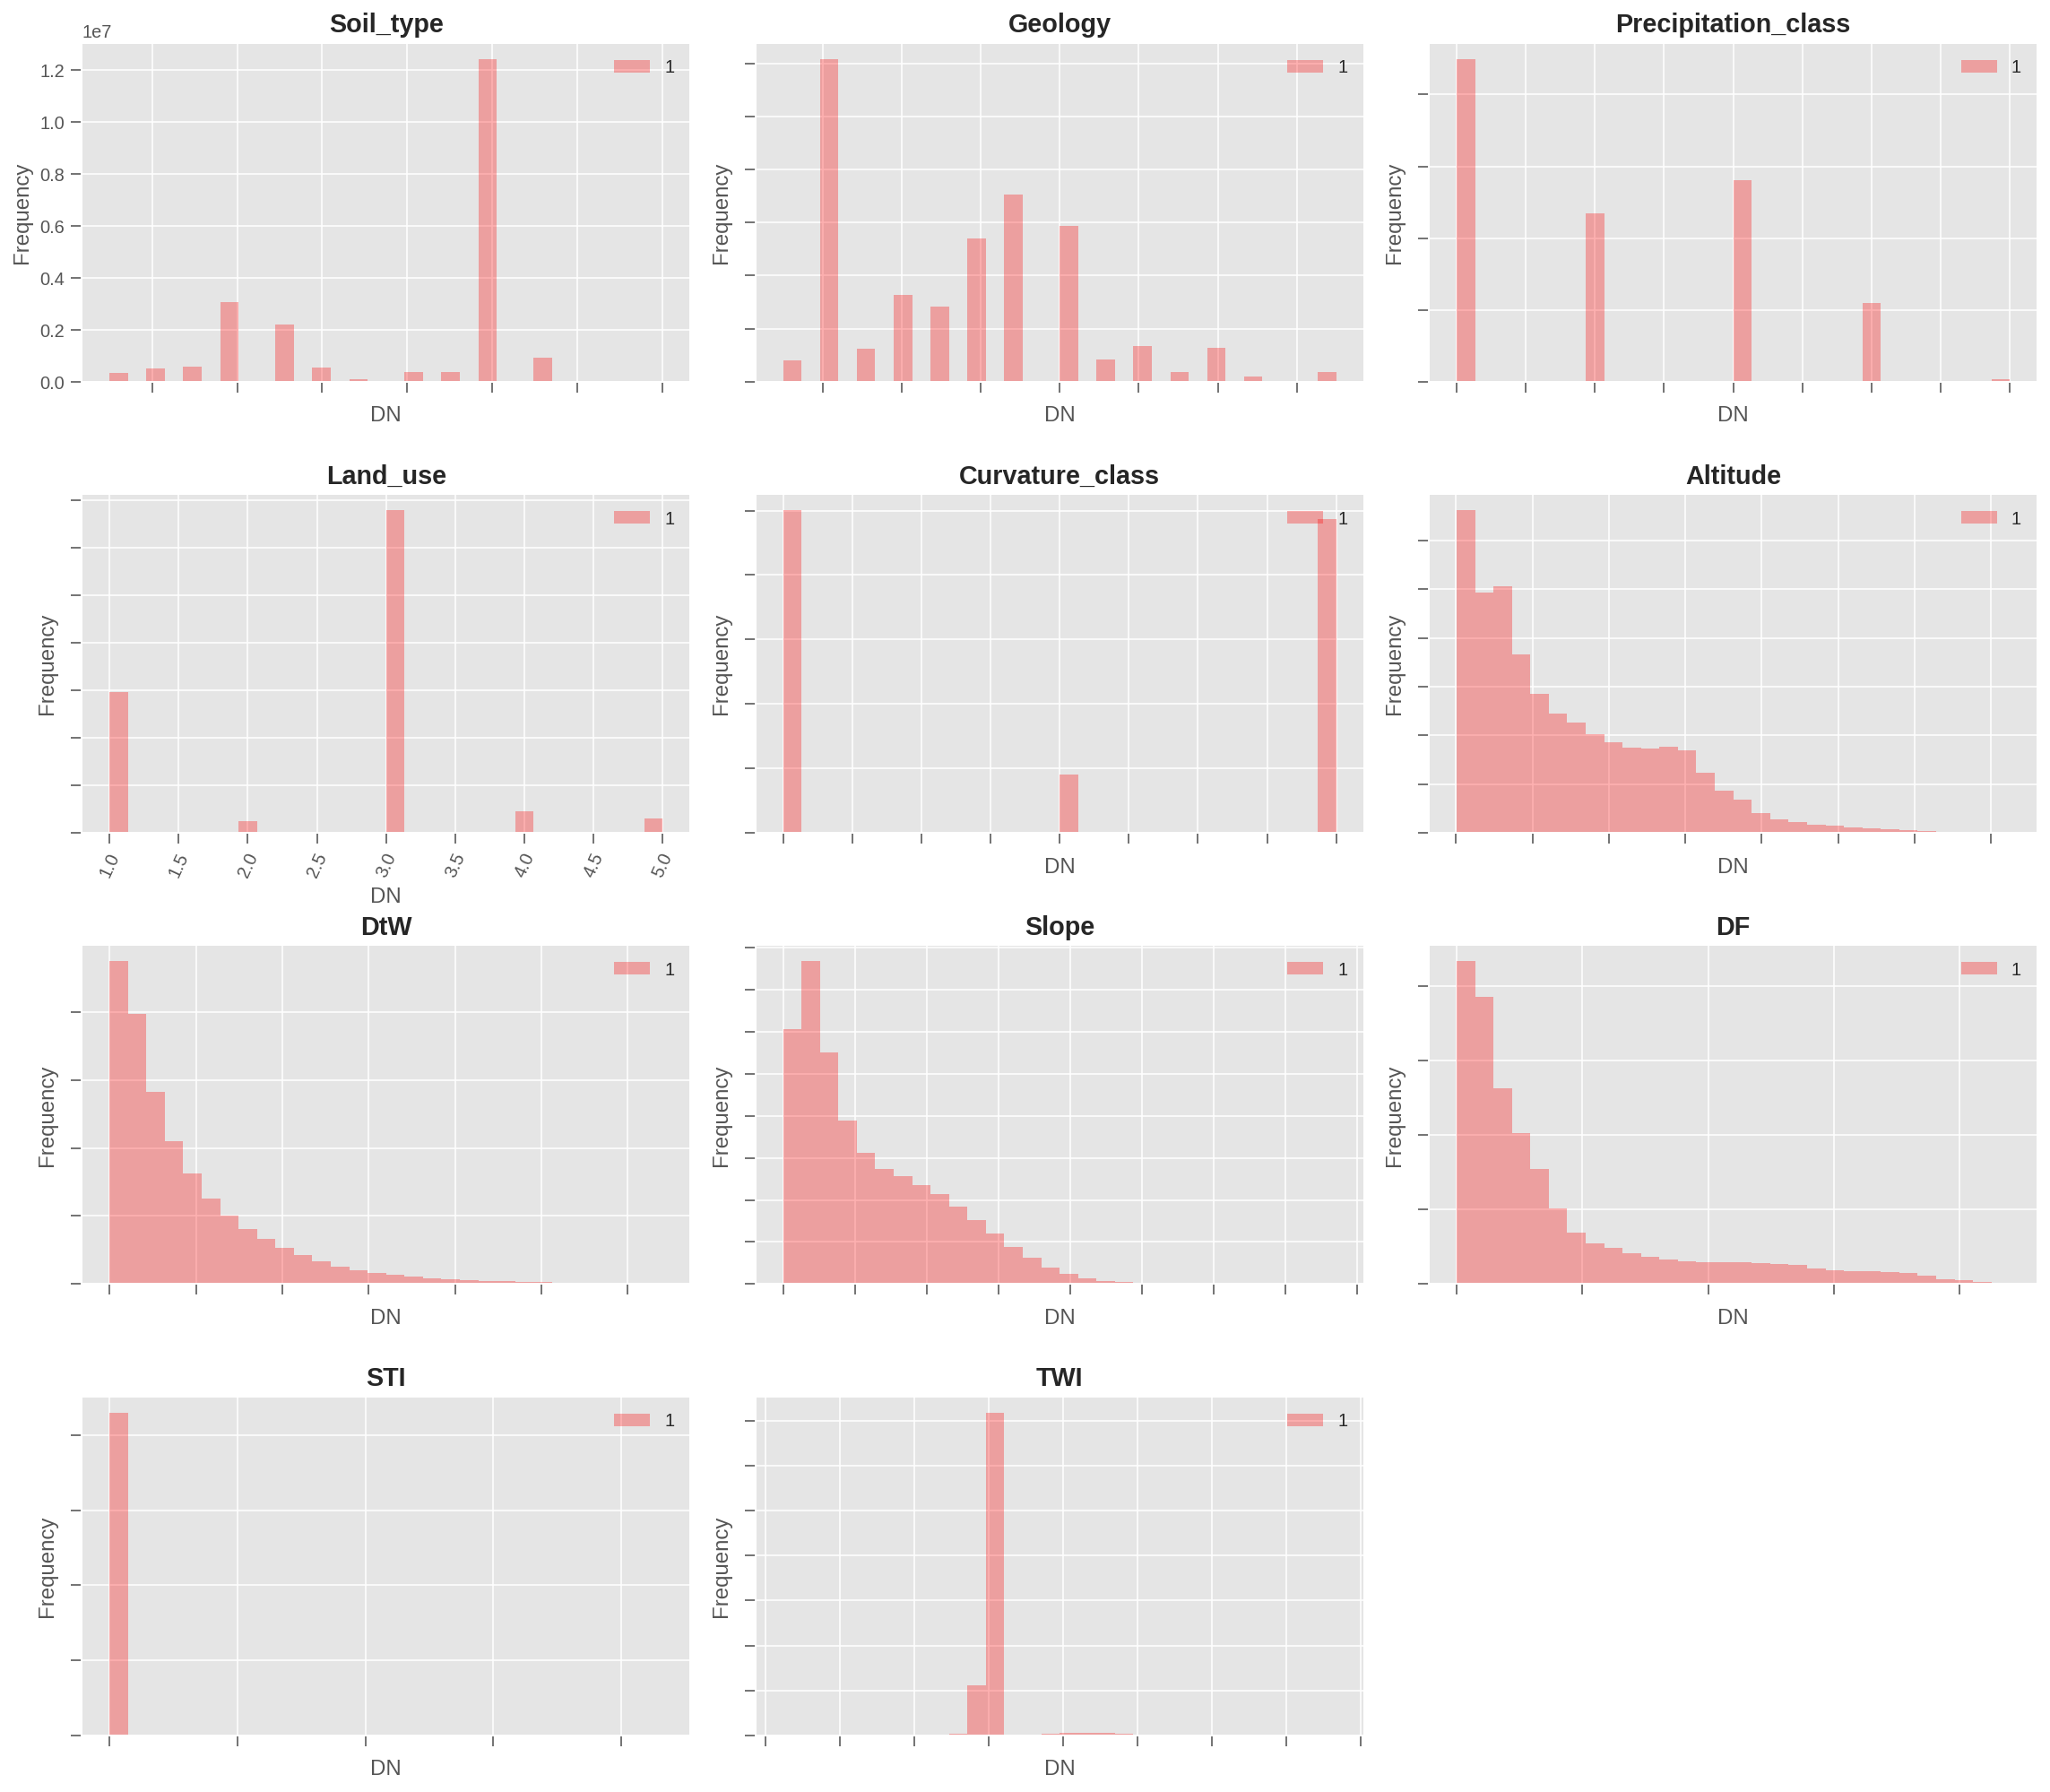

In [ ]:
## Explore the predictor distribution.
import rasterio
from rasterio.plot import show_hist
mpl.style.use('ggplot')

fig, axs = plt.subplots(4, 3, figsize=(16, 14))

for i, (ax, target,src) in enumerate(zip(axs.ravel(), list(stack.names), predictor_files)):
    src = rasterio.open(src)
    show_hist(
        src, bins=30, lw=0.0, stacked=False, alpha=0.3,
        histtype='stepfilled', title=target,ax=ax)
    
    if i != 0:
        ax.set_yticklabels([])
    
    if i != 3:
        ax.set_xticklabels([])
    else:
        ax.tick_params(axis='x', labelrotation=65)
    
fig.delaxes(axs.flatten()[i])
plt.tight_layout()

**!!! The histogram plots show that some features such as STI, TWI can be dropped from the input feature set. However, I'll just leave them there for now.**

In [ ]:
## Stack predictors into a raster stack for model training
stack = Raster(predictor_files)
stack.names

dict_keys(['Soil_type', 'Geology', 'Precipitation_class', 'Land_use', 'Curvature_class', 'Altitude', 'DtW', 'Slope', 'DF', 'STI', 'TWI', 'Aspect_9class'])

In [ ]:
## Maps the predictors for exploration
red_green=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
for lyr in stack.names:
    # stack[lyr].cmap = 'viridis'#'coolwarm'
    stack[lyr].cmap = 'coolwarm'
    # stack[lyr].cmap = red_green #'coolwarm'

mpl.style.use('seaborn-ticks')
axs = stack.plot(figsize=(16, 14))
ax = axs.flatten()[10]
im = ax.images
im[0].colorbar.set_ticks([1,2,3])
ax = axs.flatten()[8]
ax.tick_params(axis='x', labelrotation=65)

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

**!!! Curvature class feature is pretty noise**

### Explore the training dataset

In [ ]:
training_pts_file = wdir + '499_data.csv'
training_df = pd.read_csv(training_pts_file, usecols=['x','y','Yield'])
training_df.head()
training_pts = gpd.GeoDataFrame(training_df, geometry=gpd.points_from_xy(training_df.x, training_df.y))
training_pts.head()

,x,y,Yield,geometry
0,556396,1549876,20.0,POINT (556396.000 1549876.000)
1,569301,1636075,12.0,POINT (569301.000 1636075.000)
2,464618,1620454,3.0,POINT (464618.000 1620454.000)
3,552604,1606985,12.0,POINT (552604.000 1606985.000)
4,551454,1586116,8.0,POINT (551454.000 1586116.000)


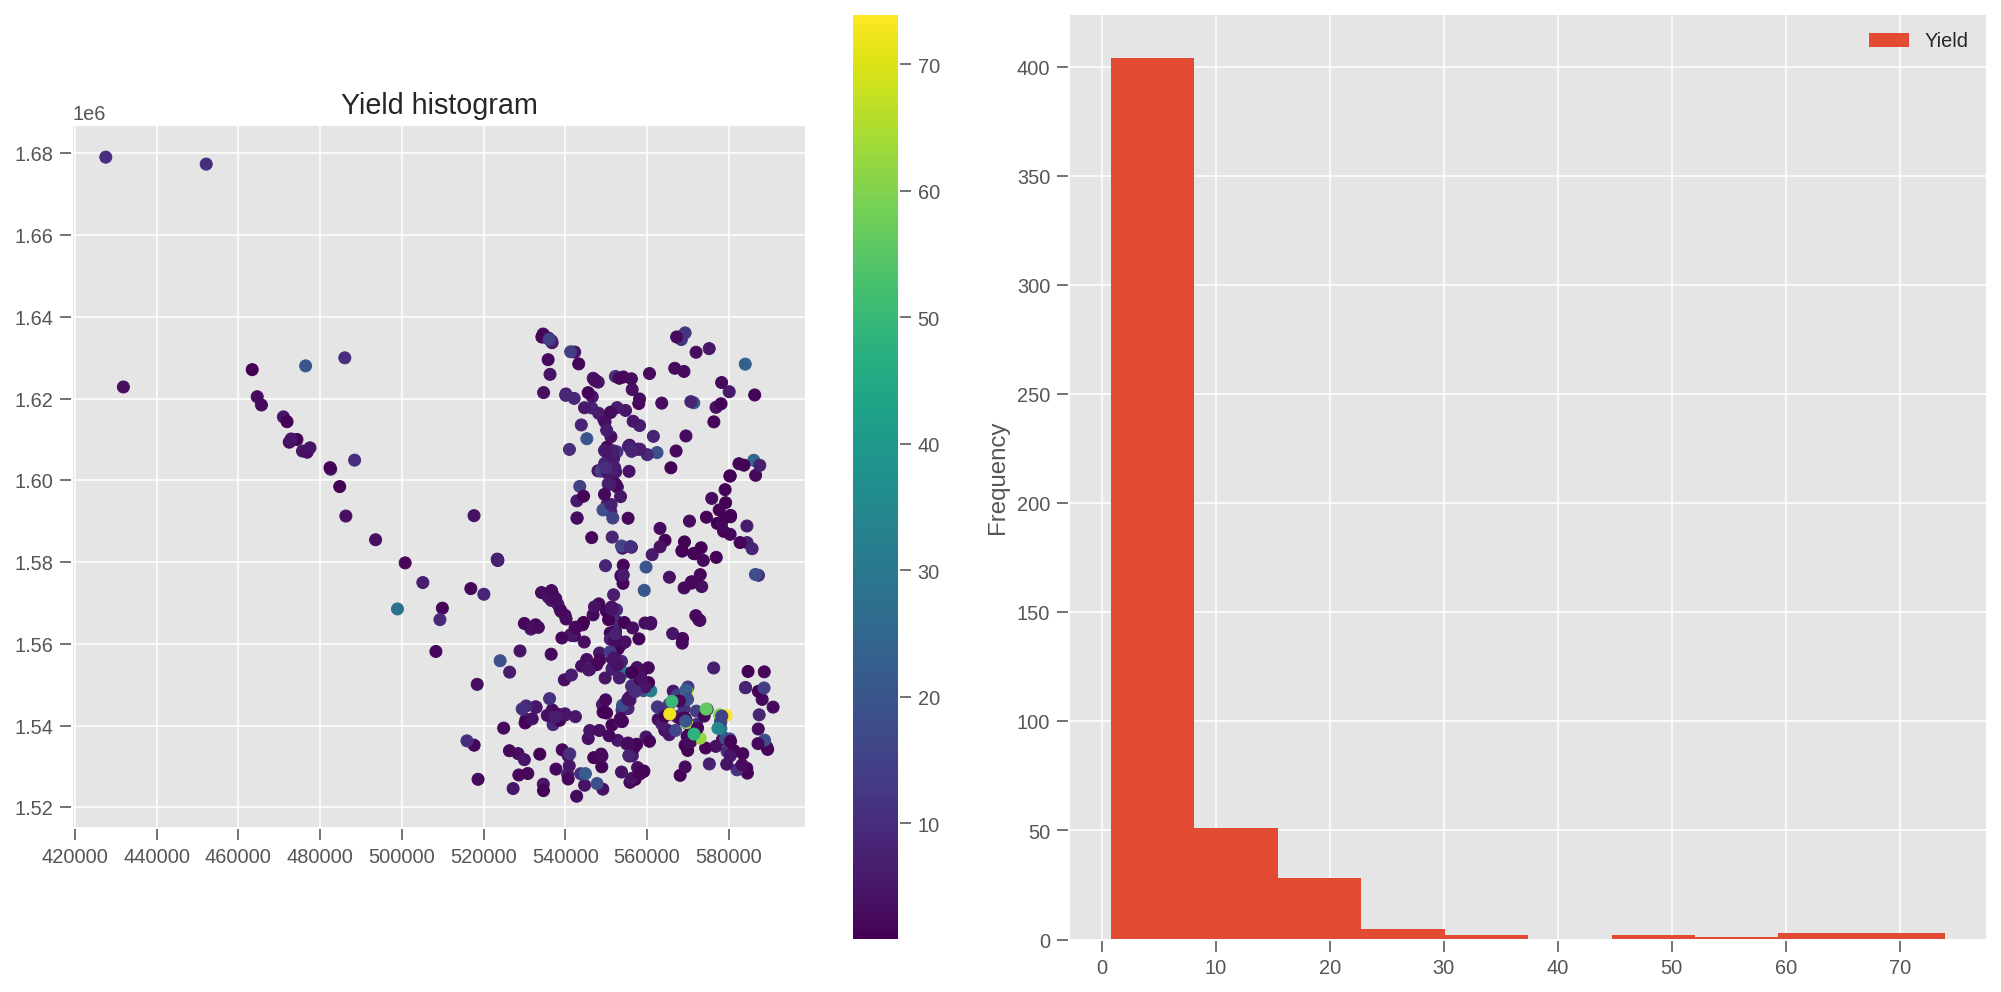

In [ ]:
## Explore the data range of the training data.
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.style.use('ggplot')

fig, axes = plt.subplots(1,2, figsize=(14, 7))
target = 'Yield'
axes[0].set_title(target.title())
training_pts.plot(column=target, legend=True, ax=axes[0], cmap='viridis')
axes[1].set_title(target.title() + ' histogram')
training_df[target].plot.hist(target,ax=axes[1], legend=True,)

plt.tight_layout()
plt.show()

**!!! The dataset doesn't have good spatial variation for model training**

### Generate new features from surrounding spatial locations, using x,y coordinates. These features will be used to calculate spatial lags for model training

In [ ]:
from pyspatialml.preprocessing import xy_coordinates

xy_layers = xy_coordinates(stack.iloc[0], NamedTemporaryFile(suffix=".tif").name)
xy_layers.rename({
    old: new for (old, new) in zip(xy_layers.names, ["x_coord", "y_coord"])},
    in_place=True
)
stack = stack.append(xy_layers, in_place=False)

Quickly plot the raster predictors with coordinates

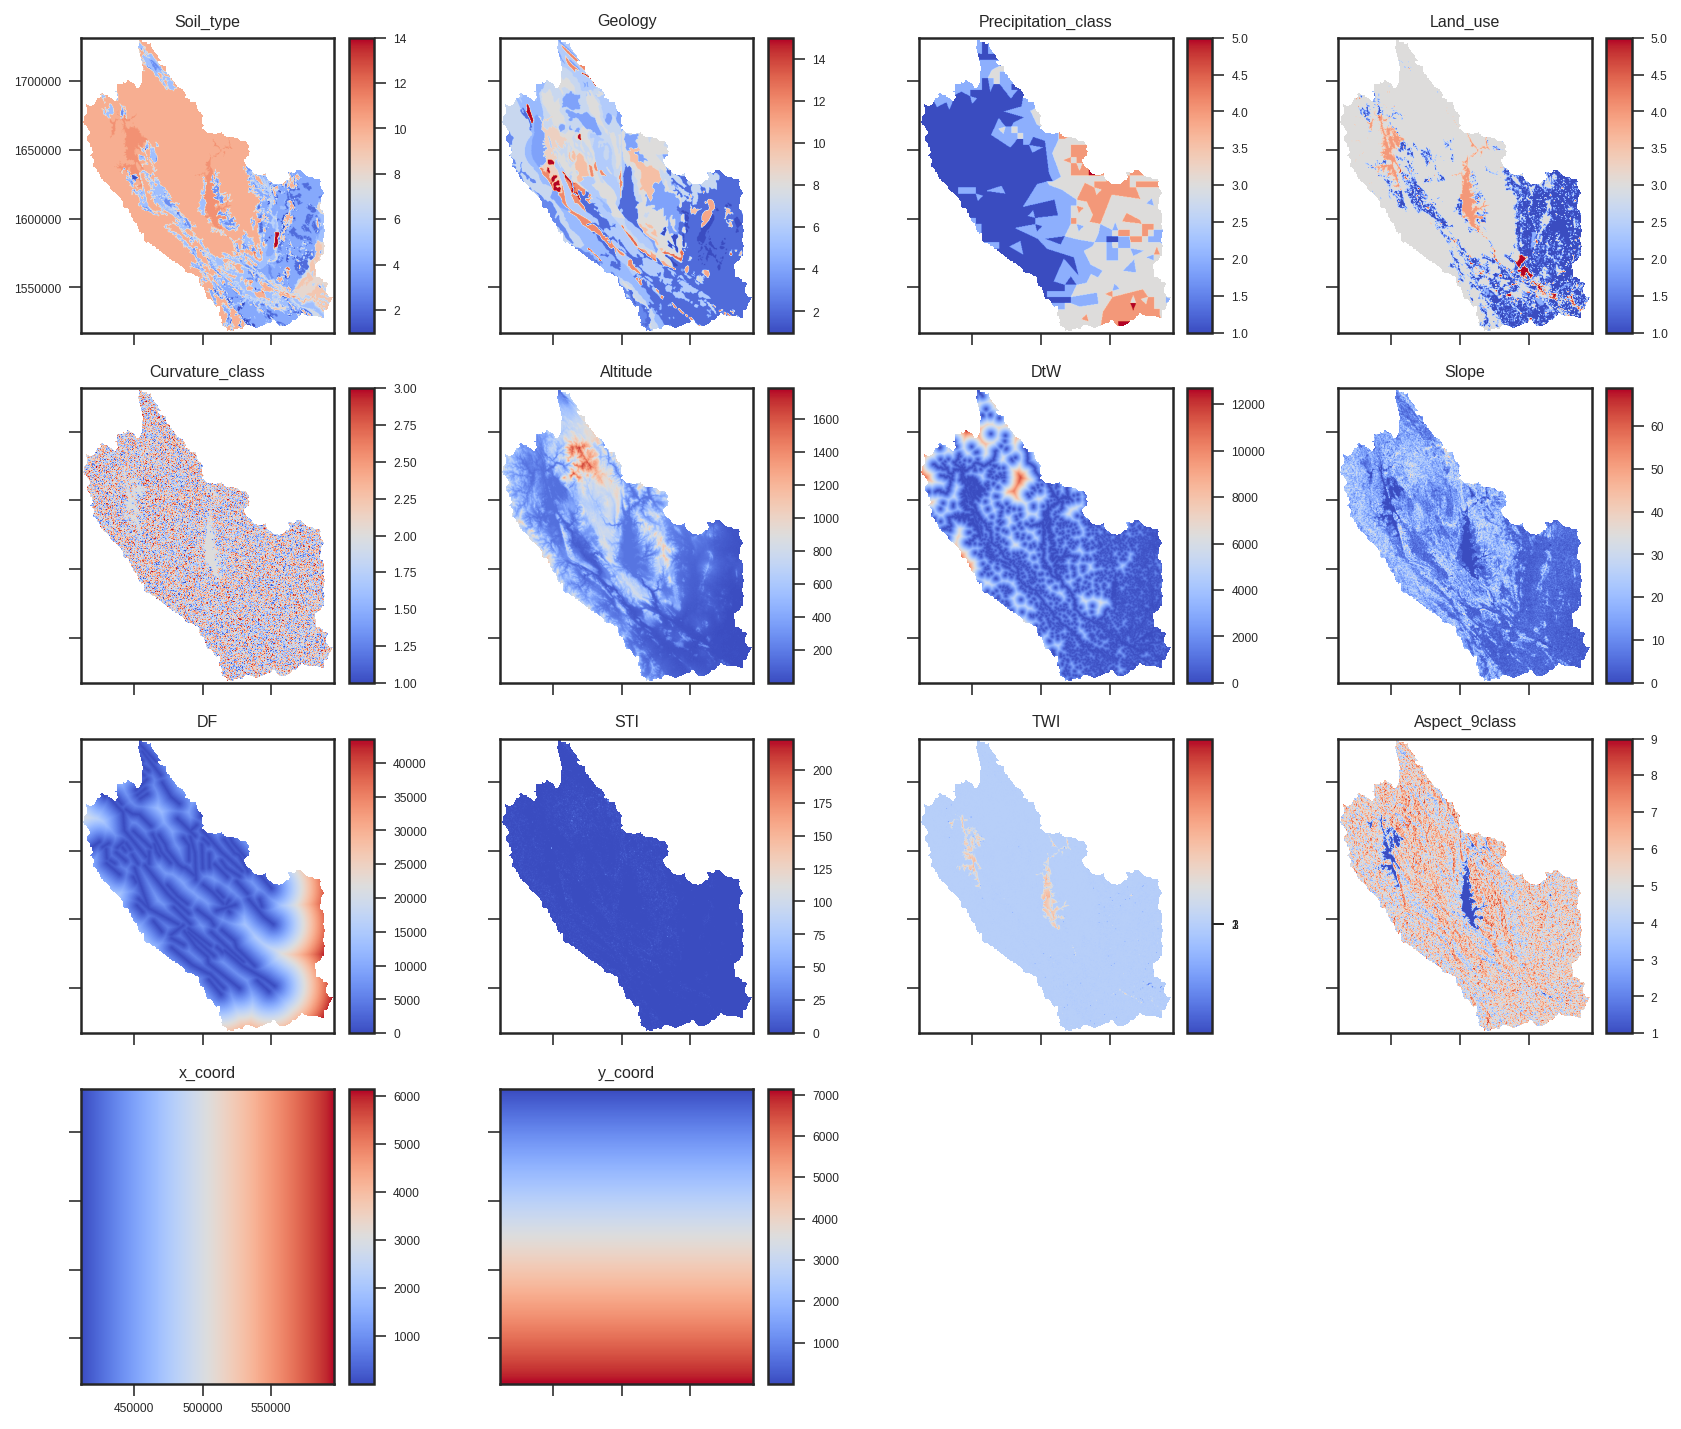

In [ ]:
for lyr in stack.names:
    stack[lyr].cmap = 'coolwarm'
mpl.style.use('seaborn-ticks')
axs = stack.plot(figsize=(12, 10))
ax = axs.flatten()[10]
im = ax.images
im[0].colorbar.set_ticks([1,2,3])
ax = axs.flatten()[8]
ax.tick_params(axis='x', labelrotation=65)

plt.tight_layout()
plt.show()

## Extract the Training Data

Spatially query the raster predictors at the training point locations:

In [ ]:
training_df = stack.extract_vector(gdf=training_pts)

training_df.index = training_df.index.get_level_values("geometry_idx")
training_df = training_df.merge(
    training_pts.loc[:, ("Yield")], 
    left_index=True, 
    right_index=True
) 
training_df = training_df.dropna()
training_df.head()

,Soil_type,Geology,Precipitation_class,Land_use,Curvature_class,Altitude,DtW,Slope,DF,STI,TWI,Aspect_9class,x_coord,y_coord,geometry,Yield
geometry_idx,,,,,,,,,,,,,,,,
0,6.0,2.0,2.0,5.0,1.0,21.0,60.000000,4.691967,4686.533691,0.209990,8.349768,7.0,4835.0,6059.0,POINT (556396.000 1549876.000),20.0
1,4.0,2.0,4.0,1.0,3.0,79.0,182.482880,6.696347,23825.232422,0.000000,-58.338406,5.0,5265.0,3186.0,POINT (569301.000 1636075.000),12.0
2,5.0,2.0,2.0,5.0,1.0,66.0,421.070068,12.303771,6236.104492,0.929882,5.015630,3.0,1776.0,3706.0,POINT (464618.000 1620454.000),3.0
3,4.0,10.0,3.0,1.0,3.0,114.0,1081.665405,4.168740,9378.155273,0.000000,-93.490935,7.0,4709.0,4155.0,POINT (552604.000 1606985.000),12.0
4,4.0,2.0,1.0,1.0,3.0,75.0,247.386337,3.181813,10145.368164,0.083683,0.017662,6.0,4670.0,4851.0,POINT (551454.000 1586116.000),8.0


Split the response/target variables from the predictors:

In [ ]:
X = training_df.loc[:, stack.names].values
y = training_df.loc[:, ['Yield']].values.ravel() # use ravel() to 1d array to flatten it
y

## Develop a Spatially-Lagged Machine Learning Model

Use ExtraTreeRegressor model with `pyspatialml.estimators.SpatialLagRegressor` metalearner class to wrap the extratrees regressor into a model that adds a new feature based on the distance-weighted mean of spatially-proximal observations:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from pyspatialml.transformers import KNNTransformer
from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import GridSearchCV

# define regressor
et = ExtraTreesRegressor(n_estimators=500, n_jobs=-1, random_state=1234)

## Transform categorical and create the lag feature using KNN
#['Soil_type', 'Geology', 'Precipitation_class', 'Land_use', 'Curvature_class', 'Altitude', 'DtW', 'Slope', 'DF', 'STI', 'TWI', 'Aspect_9class']
cat_index1 = list(stack.names).index("Soil_type")
cat_index2 = list(stack.names).index("Geology")
cat_index3 = list(stack.names).index("Curvature_class")
cat_index4 = list(stack.names).index("Aspect_9class")
cat_index5 = list(stack.names).index("Precipitation_class")
xy_indexes = [list(stack.names).index(i) for i in ["x_coord", "y_coord"]]
cat_indexes = [cat_index1,cat_index2,cat_index3,cat_index4,cat_index5]
preproc = ColumnTransformer([
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), cat_indexes),
    ('lags', KNNTransformer(weights='distance', measure="mean"), xy_indexes)
], remainder='passthrough')

wflow = Pipeline([
    ('preproc', preproc),
    ('regressor', et)
])

## Search for best hyperparameters
search_grid = {"preproc__lags__n_neighbors": [3, 5, 7, 9]}
inner = KFold(n_splits=3, shuffle=True, random_state=1234)
model = GridSearchCV(wflow, param_grid=search_grid, cv=inner, scoring="r2")

Fit the model and cross-validate:

In [ ]:
# Fit
model = model.fit(X, y)
model.best_params_

{'preproc__lags__n_neighbors': 7}

In [ ]:
# CV
outer = KFold(n_splits=10, shuffle=True, random_state=1234)
scores = cross_validate(model, X, y, scoring=['neg_mean_squared_error','r2','explained_variance','neg_mean_absolute_percentage_error'], cv=outer, n_jobs=4)
scores

{'fit_time': array([59.34979677, 60.53154349, 61.32105732, 59.40446496, 61.59205365,
        60.12309003, 59.23531318, 59.32702255, 31.25303245, 31.25282502]),
 'score_time': array([0.34654498, 0.34222984, 0.32990623, 0.34103036, 0.24182653,
        0.23720193, 0.21959162, 0.23273826, 0.21803689, 0.20696712]),
 'test_explained_variance': array([-0.11762119, -0.82970841,  0.48336681,  0.26925519,  0.09076707,
        -9.54112914, -1.33636517, -0.65100839,  0.12924776,  0.61941861]),
 'test_neg_mean_absolute_percentage_error': array([-1.14303297, -1.22197056, -1.01580005, -1.31472721, -1.28609976,
        -2.61366008, -1.43529354, -1.07863748, -0.89183032, -1.3393211 ]),
 'test_neg_mean_squared_error': array([-125.57161172, -174.47127747, -114.43611593,  -44.20222274,
         -88.73128104, -151.65472227,  -72.4723187 ,  -43.8092691 ,
         -49.26740622,  -52.43924588]),
 'test_r2': array([ -0.13692574,  -0.83173295,   0.47448165,   0.2669297 ,
          0.0890406 , -10.26580821,  -1.

In [ ]:
## RMSE metric
rmse = np.sqrt(-scores['test_neg_mean_squared_error']).mean()
print("RMSE score is {}".format(rmse))

RMSE score is 9.288762782923147


Comparing the RMSE score the the score obtained in example 1, where the spatial structure of the training data was accounted for indirectly by added a variety of raster distance measures, we can see that the RMSE score is slightly improved.

### Predictions

In [ ]:
preds = stack.predict(model)

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:488: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / 0.8)


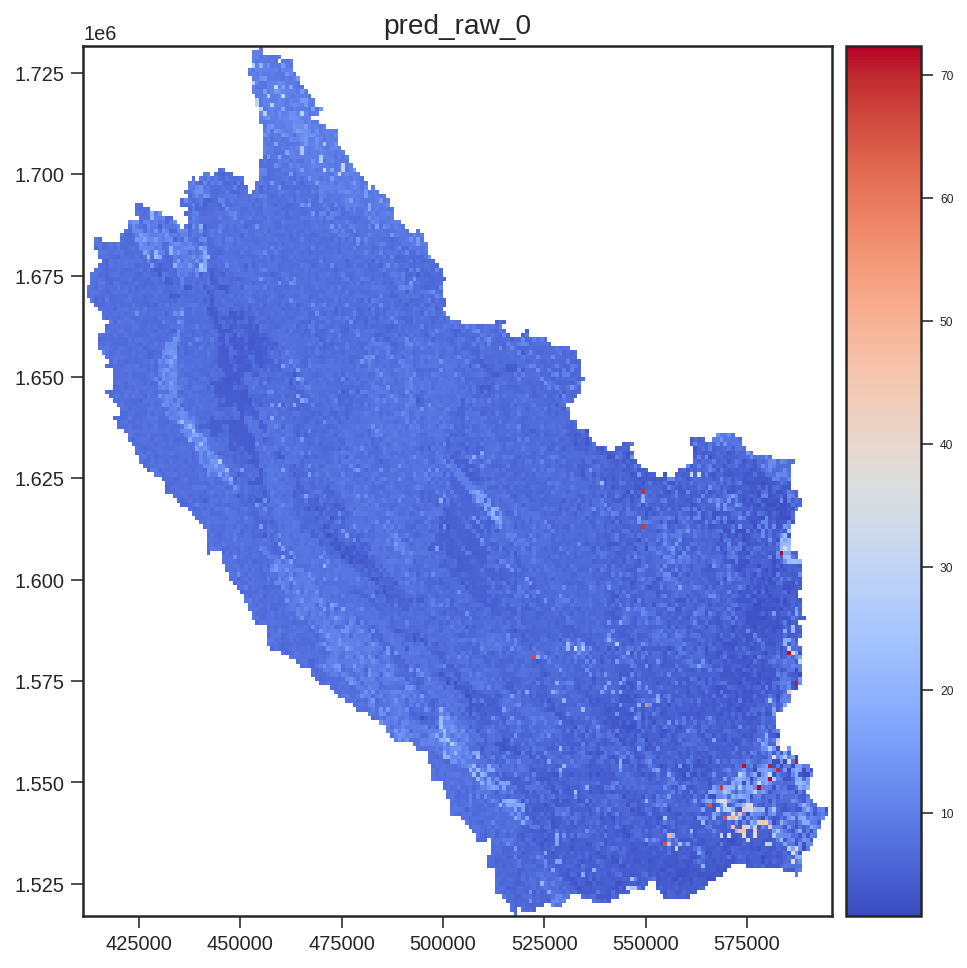

In [ ]:
## Plot prediction maps
mpl.style.use('seaborn-ticks')
f = preds.plot(out_shape=(200, 200), title_fontsize=14,figsize=(10, 8))
f.get_figure().savefig('pred_map.png')
plt.show()